# GaitRehab Explanatory Data Analysis

## Sensor Placement Breakdown & Expected Insights

| **Sensor Placement**           |   **Information**                                                                                                                   |
|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Left and Right Foot            |  Captures the start and end of stance (initial contact (heel strike) and toe-off). and swing phases                                 |
| Left and Right Shank           |  Key in modeling the swing phase and knee flexion/extension, as angular velocity signals are rich for stride and gait cycle events. |
| Left and Right Thigh           |  Helps understand hip motion, limb coordination, and interlimb timing, valuable for patients with abnormal hip/knee control.        |
| Lower Back (Sacrum/Lumbar area)|  Useful for balance, postural stability, and overall gait rhythm                                                                    |

<br/><br/>

| **Sensor Placement**           |   **Specific Meassurement**                                                                                                         |
|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Left and Right Foot            |  Stride length, stride time, cadence, step asymmetry and angular velocity helps detect gait events (peaks and zero crossings)       |
| Left and Right Shank           |  Swing dynamics, peak angular velocities during swing, stance/swing timem left and right sides for asymmetry detection              |
| Left and Right Thigh           |  Hip extension/flexion timing, detect compensatory strategies like circumduction or hip hiking                                      |
| Lower Back (Sacrum/Lumbar area)|  Symmetry of trunk motion, trunk sway in medio-lateral direction (important in stroke)                                              |

---

# Inertial Measurement Unit - IMU EDA

### IMU Accelerometer Data
Provides us a body motion information (e.g., trunk or limb acceleration) over time, which is useful for detecting gait events like heel strikes, toe-offs, stride time, and cadence.


| Axis	| Typical Meaning (depends on IMU orientation)          |
|-------|-------------------------------------------------------|
| X-axis| Forward-backward motion (anteroposterior)             |
| Y-axis| Side-to-side motion (mediolateral)                    |
| Z-axis| Up-down motion (vertical) — used most for gait events |

<br/><br/>

### IMU Gyroscope Data
Provides angular velocity of body segments like limb rotations. It is especially useful for identifying gait phase transitions, such as detecting swing vs. stance, and for estimating stride cycles, cadence, and smoothness of movement.
- During swing, angular velocity increases (due to leg rotation).
- During stance, angular velocity is close to zero (foot stable on ground).
- Peaks in gyroscope signals often correspond to maximum limb swing or mid-swing.

|Axis   | Typical Meaning (depends on IMU orientation)            |
|-------|---------------------------------------------------------|
|X-axis | Rotation around the anteroposterior axis (e.g., roll)   |
|Y-axis | Rotation around the mediolateral axis (e.g., pitch)     |
|Z-axis | Rotation around the vertical axis (e.g., yaw, leg swing)|

The typical IMU orientation can be seen on the sensor at the very front of the foot here where:
<br><br/>
<img src="./data/Information/imu_example.jpg" alt="Typical IMU orientation" width="300"/>


---

In [1]:
# Libraries
import os, sys, math, random, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

# Display settings
plt.rcParams['figure.figsize'] = (15, 5)

# Constants
data_path = "/Users/stamatiosorphanos/Documents/GaitRehab_Models/data"
healthy_directory = os.path.join(data_path, "Healthy")
stroke_directory  = os.path.join(data_path, "Stroke")

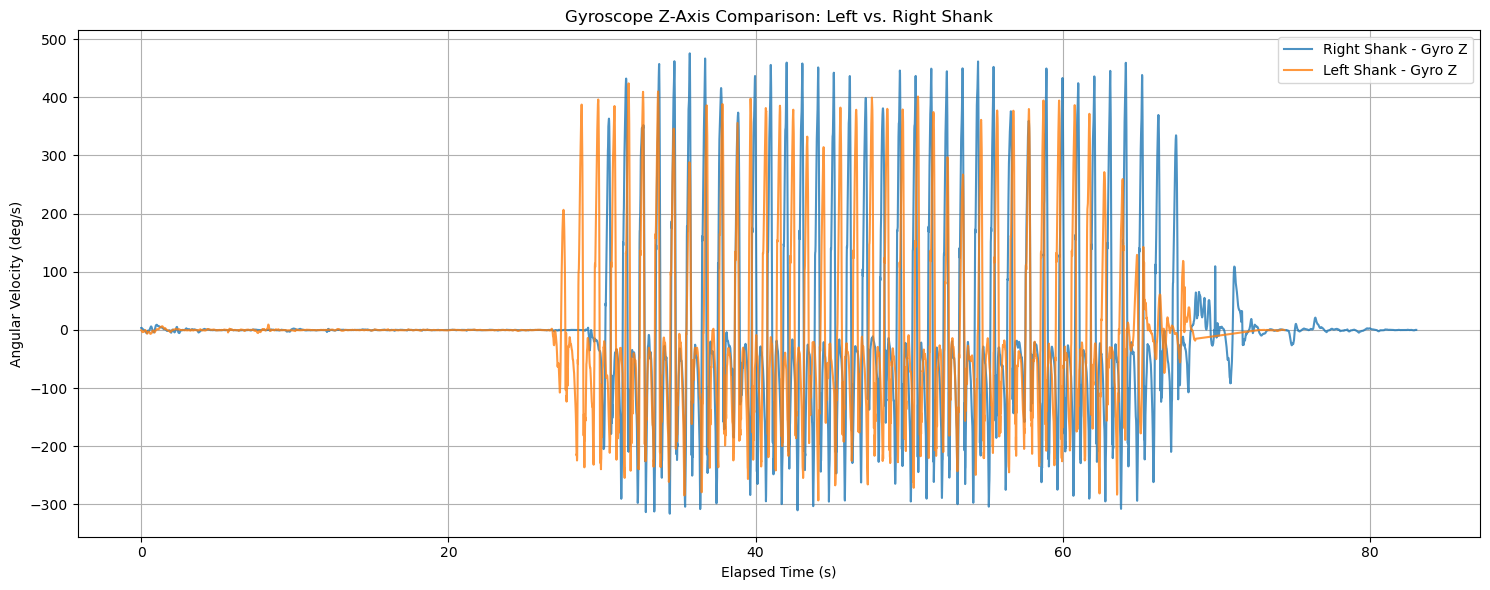

In [2]:
# File paths
gyro_right_path = os.path.join(healthy_directory, "Patient_1", "RightShank-Gyroscope.csv")
gyro_left_path = os.path.join(healthy_directory,  "Patient_1", "LeftShank-Gyroscope.csv")


# Load data 
df_gyro_right = pd.read_csv(gyro_right_path)
df_gyro_left = pd.read_csv(gyro_left_path)

# Plotting the Z-axis (dominant stride axis) from both legs for comparison
plt.figure(figsize=(15, 6))
plt.plot(df_gyro_right["elapsed (s)"], df_gyro_right["z-axis (deg/s)"], label="Right Shank - Gyro Z", alpha=0.8)
plt.plot(df_gyro_left["elapsed (s)"], df_gyro_left["z-axis (deg/s)"], label="Left Shank - Gyro Z", alpha=0.8)

plt.title("Gyroscope Z-Axis Comparison: Left vs. Right Shank")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Angular Velocity (deg/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation:
- Both signals show cyclical waveforms, which correspond to leg swings during walking.
- The amplitude and frequency appear fairly symmetrical, as expected for a healthy subject.
- This kind of rhythm is what you'd want to analyze further for stride timing, swing/stance segmentation, and asymmetry detection.

---

### Butter low-pass filter

This function is used to preprocess gait data, such as gyroscope signals, by removing noise and retaining the essential low-frequency components for further analysis. 

In [3]:
# Define a low-pass Butterworth filter
def butter_lowpass_filter(data, cutoff=6, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

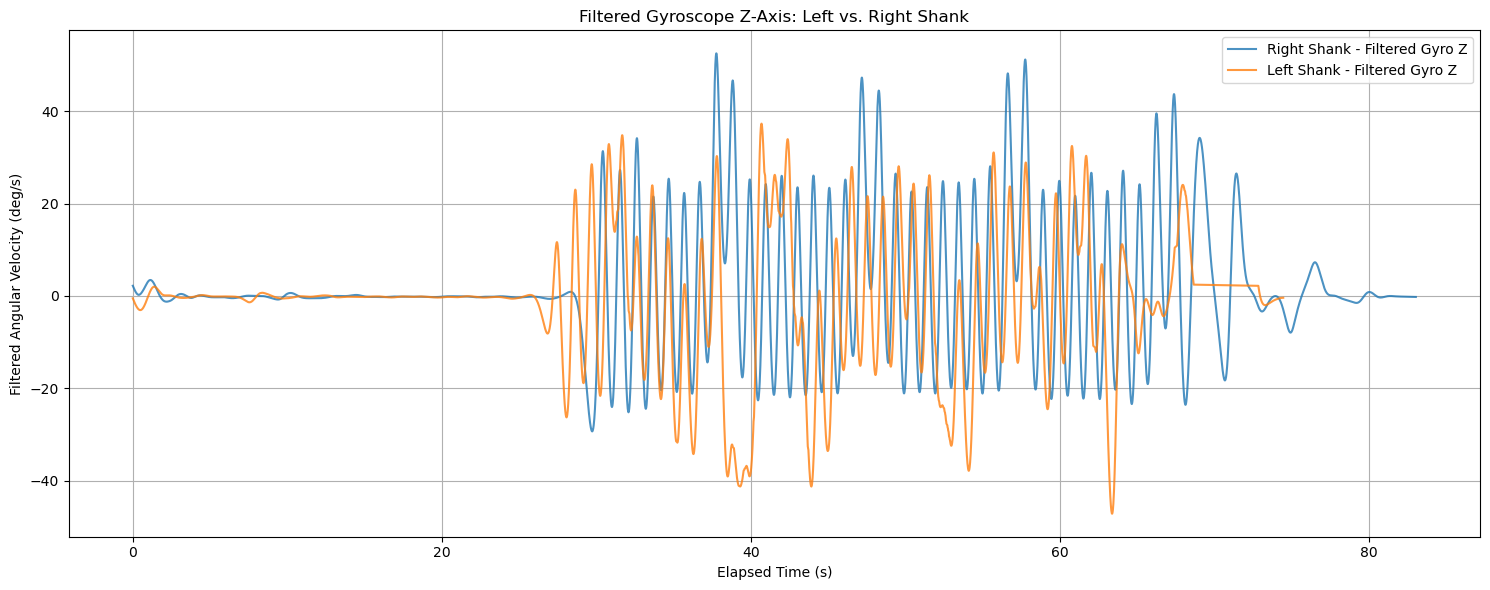

In [4]:
# Apply the filter to Z-axis gyroscope data for both legs
fs = 1000
cutoff = 6

df_gyro_right['z_filtered'] = butter_lowpass_filter(df_gyro_right['z-axis (deg/s)'], cutoff, fs)
df_gyro_left['z_filtered'] = butter_lowpass_filter(df_gyro_left['z-axis (deg/s)'], cutoff, fs)

# Plot filtered signals to compare
plt.figure(figsize=(15, 6))
plt.plot(df_gyro_right["elapsed (s)"], df_gyro_right["z_filtered"], label="Right Shank - Filtered Gyro Z", alpha=0.8)
plt.plot(df_gyro_left["elapsed (s)"], df_gyro_left["z_filtered"], label="Left Shank - Filtered Gyro Z", alpha=0.8)

plt.title("Filtered Gyroscope Z-Axis: Left vs. Right Shank")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Filtered Angular Velocity (deg/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Function to detect zero-crossings and local minima
def detect_phases(signal, time):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    stance_swing = []

    for i in range(len(zero_crossings) - 1):
        start = zero_crossings[i]
        end = zero_crossings[i + 1]
        segment = signal[start:end]
        if len(segment) == 0:
            continue
        min_idx = np.argmin(segment) + start
        stance_swing.append({
            "stance_start": time[start],
            "stance_end": time[min_idx],
            "swing_start": time[min_idx],
            "swing_end": time[end]
        })
    return stance_swing

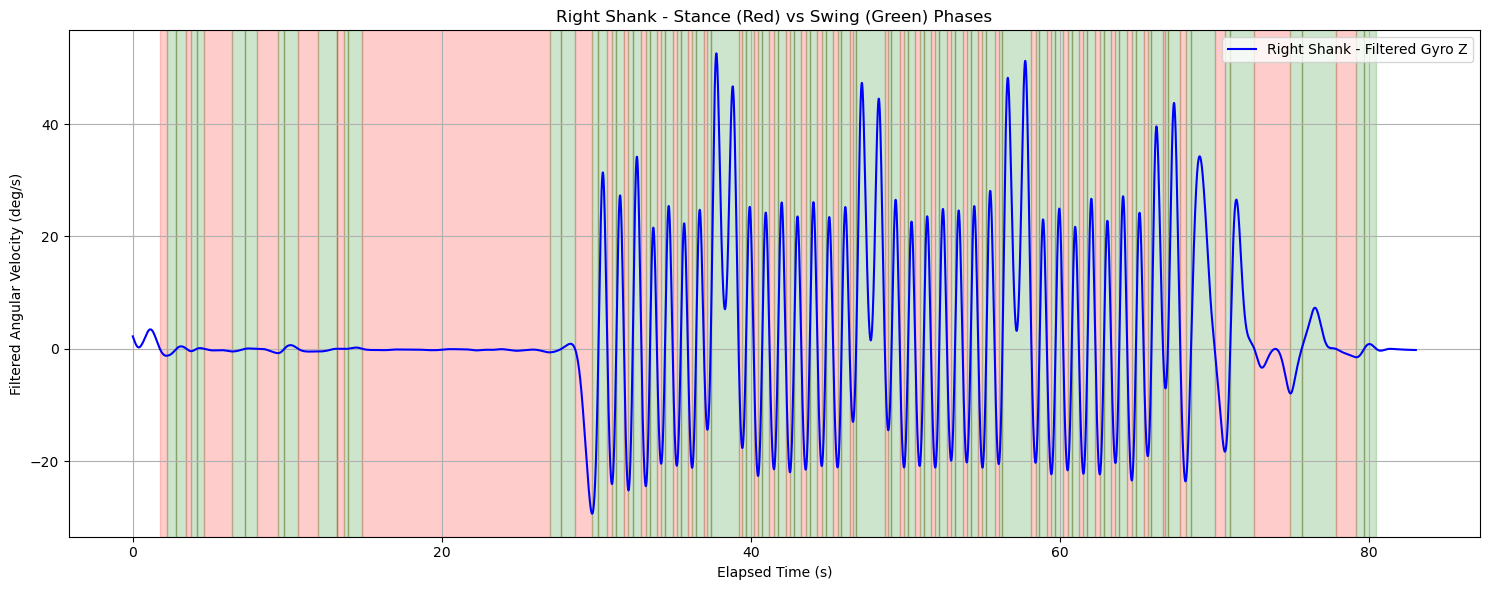

In [6]:
# Detect phases for right and left shank
phases_right = detect_phases(df_gyro_right["z_filtered"].values, df_gyro_right["elapsed (s)"].values)
phases_left = detect_phases(df_gyro_left["z_filtered"].values, df_gyro_left["elapsed (s)"].values)

# Plot with highlighted stance and swing phases
plt.figure(figsize=(15, 6))

# Right shank
plt.plot(df_gyro_right["elapsed (s)"], df_gyro_right["z_filtered"], label="Right Shank - Filtered Gyro Z", color='blue')

for phase in phases_right:
    plt.axvspan(phase["stance_start"], phase["stance_end"], color='red', alpha=0.2)
    plt.axvspan(phase["swing_start"], phase["swing_end"], color='green', alpha=0.2)

plt.title("Right Shank - Stance (Red) vs Swing (Green) Phases")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Filtered Angular Velocity (deg/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

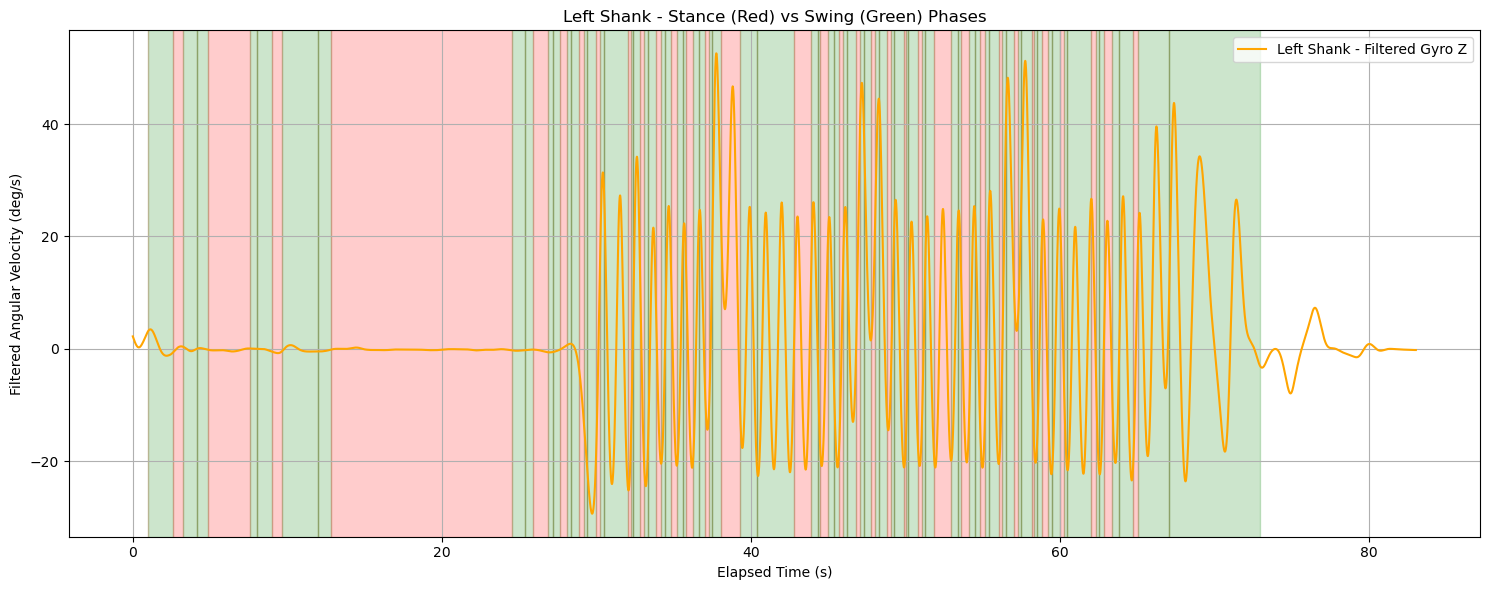

In [ ]:
# Detect phases for right and left shank
phases_left = detect_phases(df_gyro_left["z_filtered"].values, df_gyro_left["elapsed (s)"].values)

# Plot with highlighted stance and swing phases
plt.figure(figsize=(15, 6))

# Right shank
plt.plot(df_gyro_right["elapsed (s)"], df_gyro_right["z_filtered"], label="Left Shank - Filtered Gyro Z", color='orange')

for phase in phases_left:
    plt.axvspan(phase["stance_start"], phase["stance_end"], color='red', alpha=0.2)
    plt.axvspan(phase["swing_start"], phase["swing_end"], color='green', alpha=0.2)

plt.title("Left Shank - Stance (Red) vs Swing (Green) Phases")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Filtered Angular Velocity (deg/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

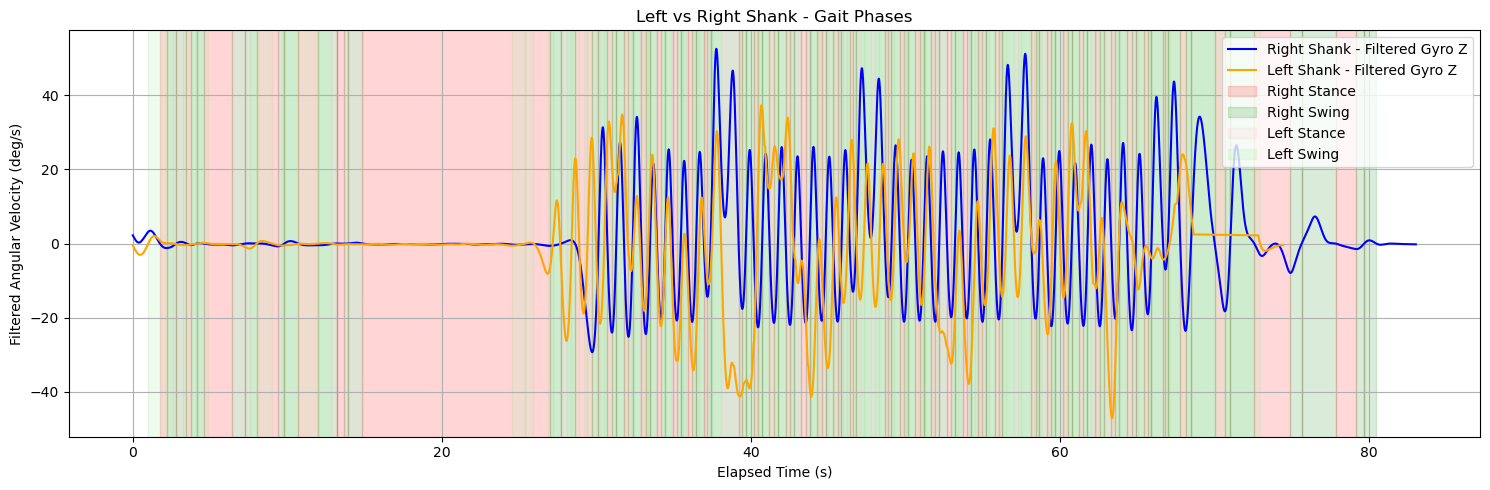

In [9]:
# Plot filtered Z-axis signals
plt.plot(df_gyro_right["elapsed (s)"], df_gyro_right["z_filtered"], label="Right Shank - Filtered Gyro Z", color='blue')
plt.plot(df_gyro_left["elapsed (s)"], df_gyro_left["z_filtered"], label="Left Shank - Filtered Gyro Z", color='orange')

# Overlay stance and swing phases
for phase in phases_right:
    plt.axvspan(phase["stance_start"], phase["stance_end"], color='red', alpha=0.15, label='Right Stance' if phase == phases_right[0] else "")
    plt.axvspan(phase["swing_start"], phase["swing_end"], color='green', alpha=0.15, label='Right Swing' if phase == phases_right[0] else "")

for phase in phases_left:
    plt.axvspan(phase["stance_start"], phase["stance_end"], color='pink', alpha=0.15, label='Left Stance' if phase == phases_left[0] else "")
    plt.axvspan(phase["swing_start"], phase["swing_end"], color='lightgreen', alpha=0.15, label='Left Swing' if phase == phases_left[0] else "")

plt.title("Left vs Right Shank - Gait Phases")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Filtered Angular Velocity (deg/s)")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()